In [1]:
%matplotlib inline
import numpy as np

X-bar label automatically set to:  33.4  Using the format %.1f  --> adjust it and add units through the format !
Y-bar label automatically set to:  43.6  Using the format %.1f  --> adjust it and add units through the format !
X-bar label automatically set to:  33.4  Using the format %.1f  --> adjust it and add units through the format !
Y-bar label automatically set to:  43.6  Using the format %.1f  --> adjust it and add units through the format !
X-bar label automatically set to:  33.4  Using the format %.1f  --> adjust it and add units through the format !
Y-bar label automatically set to:  43.6  Using the format %.1f  --> adjust it and add units through the format !
X-bar label automatically set to:  33.4  Using the format %.1f  --> adjust it and add units through the format !
Y-bar label automatically set to:  43.6  Using the format %.1f  --> adjust it and add units through the format !
X-bar label automatically set to:  33.4  Using the format %.1f  --> adjust it and add units thro

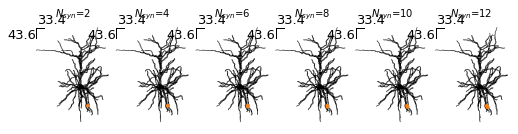

In [2]:
%run nmda-spike syn-demo

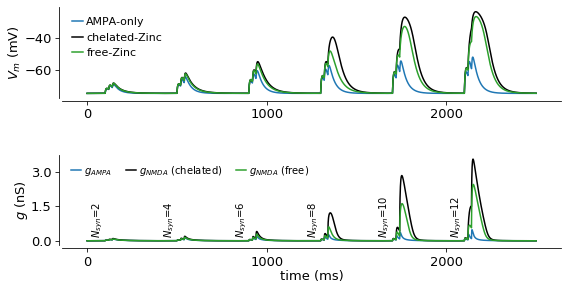

In [3]:
%run nmda-spike demo-plot

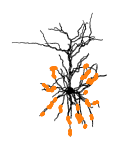

31 segments


In [4]:
%run nmda-spike locations

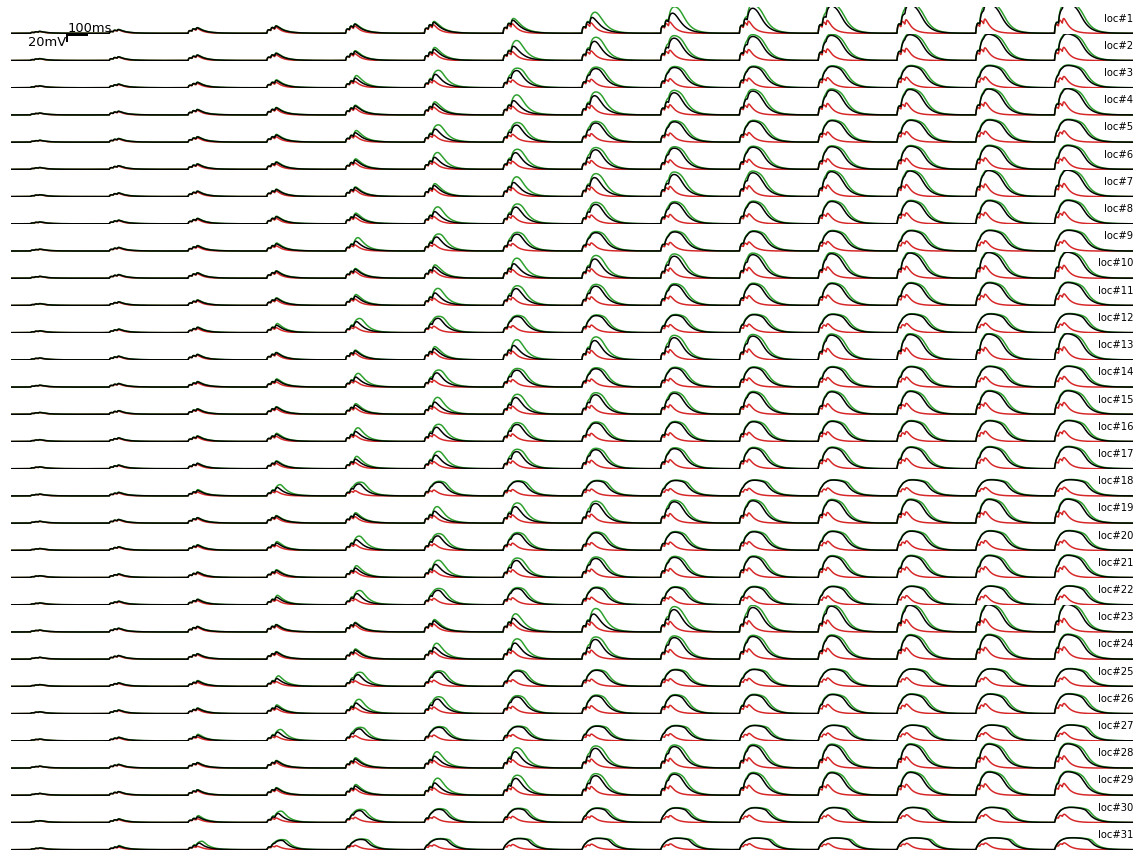

In [27]:
fig, AX = ge.figure(axes=(1, len(LOCs)), figsize=(3.,.3), hspace=0)
for i, loc in enumerate(LOCs):
    data = load_dict('data/nmda-spike/data-loc-%i-AMPA-only.npz' % loc)
    AX[i].plot(data['t'], data['Vm_soma'], color=ge.red)
    data = load_dict('data/nmda-spike/data-loc-%i-chelated-Zinc.npz' % loc)
    AX[i].plot(data['t'], data['Vm_soma'], color=ge.green)
    data = load_dict('data/nmda-spike/data-loc-%i-free-Zinc.npz' % loc)
    AX[i].plot(data['t'], data['Vm_soma'], color='k')
    ge.annotate(AX[i], 'loc#%i' % (i+1), (1.,.4), size='xx-small', ha='right')
    ge.set_plot(AX[i], [], xlim=[data['t'][0], data['t'][-1]], ylim=[-76, -30])
ge.draw_bar_scales(AX[1], Xbar=100, Ybar=10, loc='left-top', Xbar_label='100ms', Ybar_label='20mV', lw=2)
    


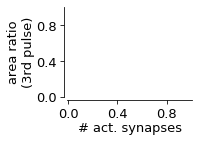

In [31]:
fig, ax = ge.figure()
# for i, loc in enumerate(LOCs):
#     data0 = load_dict('data/nmda-spike/data-loc-%i-AMPA-only.npz' % loc)
#     data1 = load_dict('data/nmda-spike/data-loc-%i-chelated-Zinc.npz' % loc)
#     ax.plot(data['NSYNs'], data['Vm_soma'], color=ge.red)
#     AX[i].plot(data['t'], data['Vm_soma'], color=ge.green)
#     data2 = load_dict('data/nmda-spike/data-loc-%i-free-Zinc.npz' % loc)
#     AX[i].plot(data['t'], data['Vm_soma'], color='k')
#     ge.annotate(AX[i], 'loc#%i' % (i+1), (1.,.4), size='xx-small', ha='right')




In [77]:
np.argwhere(data['NSYNs']==10)

array([[9]])

In [97]:
NSYNS = np.arange(1, 12)
NSYNS

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [98]:
get_third_pulse_cond_ratios(loc, NSYNs)

[2, 4, 6, 8, 10, 12]


IndexError: list index out of range

In [122]:


def get_third_pulse_cond_areas(loc, NSYNs):

    data0 = load_dict('data/nmda-spike/data-loc-%i-AMPA-only.npz' % loc)
    data1 = load_dict('data/nmda-spike/data-loc-%i-chelated-Zinc.npz' % loc)
    data2 = load_dict('data/nmda-spike/data-loc-%i-free-Zinc.npz' % loc)
    area0, area1, area2 = 0*NSYNs, 0*NSYNs, 0*NSYNs
    for i in range(len(NSYNs)):
        insyn = np.argwhere(data['NSYNs']==NSYNs[i])[0][0]
        Third_pulse_cond = (data0['t']>data0['events'][insyn]+40) & (data0['t']<data0['events'][insyn]+60)
        area0[i] = np.trapz(data0['Vm_soma'][Third_pulse_cond]+75, x=data0['t'][Third_pulse_cond])
        area1[i] = np.trapz(data1['Vm_soma'][Third_pulse_cond]+75, x=data0['t'][Third_pulse_cond])
        area2[i] = np.trapz(data2['Vm_soma'][Third_pulse_cond]+75, x=data0['t'][Third_pulse_cond])
    return area0, area1, area2



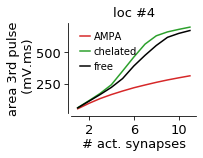

In [165]:
loc = 4

NSYNs = np.arange(1, 12)

area0, area1, area2 = get_third_pulse_cond_areas(LOCs[loc], NSYNs)
fig, ax = ge.figure()
ax.plot(NSYNs, area0, color=ge.red, label='AMPA')
ax.plot(NSYNs, area1, color=ge.green, label='chelated')
ax.plot(NSYNs, area2, color='k', label='free')
ge.legend(ax, size='xx-small')
ge.title(ax, 'loc #%i' % loc)
ge.set_plot(ax, ylabel='area 3rd pulse\n (mV.ms)', xlabel='# act. synapses', xticks=[2,6,10])

(<Figure size 238.11x204.094 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd2dd9f2810>)

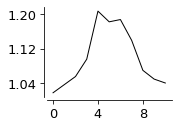

In [169]:
ge.plot(area1/area2)

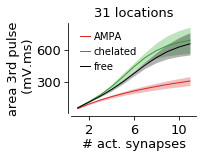

In [156]:
NSYNs = np.arange(1, 12)
Area0, Area1, Area2 = np.zeros((len(NSYNs), len(LOCs))), np.zeros((len(NSYNs), len(LOCs))), np.zeros((len(NSYNs), len(LOCs)))
for i in range(len(LOCs)):
    
    Area0[:,i], Area1[:,i], Area2[:,i] = get_third_pulse_cond_areas(LOCs[i], NSYNs)
    
fig, ax = ge.figure()
ge.plot(NSYNs, np.mean(Area0, axis=1), sy=np.std(Area0, axis=1), color=ge.red, label='AMPA', ax=ax, no_set=True)
ge.plot(NSYNs, np.mean(Area1, axis=1), sy=np.std(Area1, axis=1), color=ge.green, label='chelated', ax=ax, no_set=True)
ge.plot(NSYNs, np.mean(Area2, axis=1), sy=np.std(Area2, axis=1), color='k', label='free', ax=ax, no_set=True)
# ax.plot(NSYNs, area1, 
# ax.plot(NSYNs, area2, color='k', label='free')
ge.legend(ax, size='xx-small')
ge.title(ax, '%i locations' % len(LOCs))
ge.set_plot(ax, ylabel='area 3rd pulse\n (mV.ms)', xlabel='# act. synapses', xticks=[2,6,10])

In [ ]:
NSYNs = np.arange(1, 12)
Area0, Area1, Area2 = np.zeros((len(NSYNs), len(LOCs))), np.zeros((len(NSYNs), len(LOCs))), np.zeros((len(NSYNs), len(LOCs)))
for i in range(len(LOCs)):
    
    Area0[:,i], Area1[:,i], Area2[:,i] = get_third_pulse_cond_areas(LOCs[i], NSYNs)
    
fig, ax = ge.figure()
ge.plot(NSYNs, np.mean(Area0, axis=1), sy=np.std(Area0, axis=1), color=ge.red, label='AMPA', ax=ax, no_set=True)
ge.plot(NSYNs, np.mean(Area1, axis=1), sy=np.std(Area1, axis=1), color=ge.green, label='chelated', ax=ax, no_set=True)
ge.plot(NSYNs, np.mean(Area2, axis=1), sy=np.std(Area2, axis=1), color='k', label='free', ax=ax, no_set=True)
# ax.plot(NSYNs, area1, 
# ax.plot(NSYNs, area2, color='k', label='free')
ge.legend(ax, size='xx-small')
ge.title(ax, '%i locations' % len(LOCs))
ge.set_plot(ax, ylabel='area 3rd pulse\n (mV.ms)', xlabel='# act. synapses', xticks=[2,6,10])

In [36]:
from datavyz import ge
from analyz.IO.npz import load_dict
from scipy.interpolate import interp1d

/home/yann/miniconda3/lib/python3.8/site-packages/datavyz/adjust_plots.py:164: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  spine.set_smart_bounds(True)


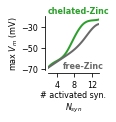

In [55]:
fig, ax = ge.figure(figsize=(.9,1.2))

COLORS = [ge.green, 'dimgrey']
x = np.linspace(2, 14)
for i, key in enumerate(['chelated-Zinc', 'free-Zinc']):
    
    X, Y = [], []
    data = load_dict('data/nmda-spike/demo-%s.npz' % key)
    for e, n in zip(data['events'], data['NSYNs']):
        cond = (data['t']>e) & (data['t']<e+100)
        Y.append(data['Vm_soma'][cond].max())#-data['Vm_soma'][0])
        X.append(n)
    
    func = interp1d(X, Y, kind='cubic')
    ax.plot(x, func(x), lw=2, color=COLORS[i])
    ge.annotate(ax, key, (i*.3, 1-i), color=COLORS[i], bold=True)
ge.set_plot(ax, ylabel='max $V_m$ (mV)', xlabel='# activated syn.\n$N_{syn}$',
            xlim=[2,13.5], 
            yticks=[-70, -50, -30])
fig.savefig('/home/yann/downloads/Figure_3.svg')

In [38]:
interp1d